# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and False:
  from google.colab import drive
  drive.mount('/content/drive')
#os.chdir(find_path('part2_pytorch.ipynb')[0][1])

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

##### Получение данных

In [3]:
import json

cred = json.load(open('kaggle.json'))
os.environ["KAGGLE_USERNAME"] = cred['username']
os.environ["KAGGLE_KEY"] = cred['key']

In [4]:
!KAGGLE_USERNAME=
!kaggle competitions download -c job-salary-prediction

 97% 309M/318M [00:04<00:00, 99.4MB/s]
100% 318M/318M [00:05<00:00, 65.8MB/s]


In [5]:
!unzip 'job-salary-prediction.zip'

Archive:  job-salary-prediction.zip
  inflating: Location_Tree.csv       
  inflating: Test_rev1.7z            
  inflating: Test_rev1.zip           
  inflating: Train_rev1.7z           
  inflating: Train_rev1.zip          
  inflating: Valid_rev1.7z           
  inflating: Valid_rev1.csv          
  inflating: mean_benchmark.csv      
  inflating: random_forest_benchmark_test_rev1.csv  
  inflating: test.csv                


In [6]:
!sudo apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [7]:
!7za x Train_rev1.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 69040196 bytes (66 MiB)

Extracting archive: Train_rev1.7z
--
Path = Train_rev1.7z
Type = 7z
Physical Size = 69040196
Headers Size = 131
Method = LZMA:24
Solid = -
Blocks = 1

  0%      4% - Train_rev1.csv                       8% - Train_rev1.csv                      13% - Train_rev1.csv                      18% - Train_rev1.csv                      22% - Train_rev1.csv                      27% - Train_rev1.csv                      32% - Train_rev1.csv

##### Считывание данных

In [8]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
11767,66540766,Cleaner Milford Primary School,Are you able to work on your own initiative? D...,Matlock,Matlock,part_time,NaN,Derbyshire County Council 2,Maintenance Jobs,6.30 per hour,12096,Jobcentre Plus,9.400713
53984,68675797,Adjudicator,Our Client is a Not for Profit financial servi...,East London London South East,South East London,NaN,permanent,Randstad Sales,Customer Services Jobs,22000 per annum + Excellent benefits,22000,totaljobs.com,9.998843
26938,67887864,Mechanical Associate,Mechanical Associate Engineer Hampshire Salary...,Christchurch Dorset South West,Christchurch,NaN,permanent,NaN,IT Jobs,65000,65000,technojobs.co.uk,11.082158


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [9]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [10]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [11]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [12]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
  data[col].apply(lambda l: token_counts.update(l.split()))

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

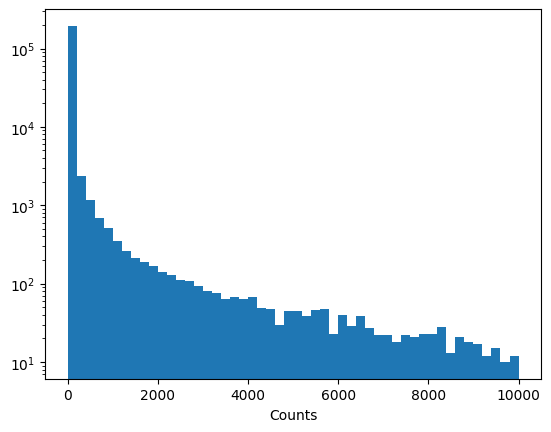

In [14]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count>=min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [17]:
token_to_id = { token:indx for indx, token in enumerate(tokens)}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [19]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [22]:
data[categorical_columns].apply(dict, axis=1)

0         {'Category': 'Engineering Jobs', 'Company': 'G...
1         {'Category': 'Engineering Jobs', 'Company': 'G...
2         {'Category': 'Engineering Jobs', 'Company': 'G...
3         {'Category': 'Engineering Jobs', 'Company': 'G...
4         {'Category': 'Engineering Jobs', 'Company': 'G...
                                ...                        
244763    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244764    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244765    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244766    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
244767    {'Category': 'Teaching Jobs', 'Company': 'NaN'...
Length: 244768, dtype: object

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [23]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [24]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)

    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

In [66]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[  18, 1569, 1636,    1,    1,    1,    1,    1,    1],
        [3094,   97,   63, 3101,   15, 2645,   15, 5946,   64],
        [2004,   60,    6, 1689,    1,    1,    1,    1,    1]],
       dtype=int32),
 'FullDescription': array([[13576,    57,   971,  7460,  1166,    86, 12431,   332,    18,
           320],
        [  177,  2719,  1166,  3094,    97,   765,  1414,    74,    74,
            73],
        [ 2004,    60,     6,  3199,   558,   560,   561,  1270,  6568,
            15]], dtype=int32),
 'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.71444 , 10.463132,  9.903538], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [26]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [71]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.relu=nn.ReLU()
        self.dense = nn.Linear(out_size, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 =  self.conv1(h)
        h2 = self.pool1(h1)
        h3 = self.relu(h2)
        h4 = self.dense(h3)

        return h4

In [72]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

torch.Size([3, 8])
torch.Size([3, 8, 64])
Seems fine


__Task 2.1__ Create description encoder

In [44]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, size1=512, size2=256, size3=128):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, size1, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(size1, size2, kernel_size=3, padding=1)
        self.relu1=nn.ReLU()

        self.conv2 = nn.Conv1d(size2, size3, kernel_size=3, padding=1)
        self.batchNorm2 = nn.BatchNorm1d(size3)
        self.pool2 = GlobalMaxPooling()
        self.relu2=nn.ReLU()

        self.dense3 = nn.Linear(size3, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = self.conv1(h)
        h2 = self.relu1(h1)
        h3 = self.conv2(h2)
        h4 = self.batchNorm2(h3)
        h5 = self.pool2(h4)
        h6 = self.relu2(h5)
        h7 = self.dense3(h6)

        return h7

In [45]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [32]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)

        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )

        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Sequential(
            nn.Linear(64*3, 256),
            nn.Linear(256, 64),
            nn.Linear(64, 1))# number 3 corresponds to title, description, and category


    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """


        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        cat_h = self.cat_encoder(cat_features)

        # concatenate all vectors together
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1) #shape [32, 192]

        out = self.out(joint_h)
        out = torch.flatten(out) # ensuring output is 1D

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return out

In [33]:
device = 'cuda'
model = FullNetwork()
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [34]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [35]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [36]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [50]:
from tqdm import tnrange, notebook
import tqdm
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]

    irange = tqdm.notebook.trange if verbose else range

    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [51]:
num_epochs = 15
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [52]:
for epoch_i in range(num_epochs):
    print(f'###############____________________Epoch {epoch_i}____________________###############')
    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference, prediction).data.cpu().numpy()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()
            val_batches += 1
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

###############____________________Epoch 0____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17818
	MAE:	4046.00648



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16478
	MAE:	4382.25922



###############____________________Epoch 1____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18321
	MAE:	4295.51035



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17562
	MAE:	4533.20232



###############____________________Epoch 2____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.32784
	MAE:	5919.70191



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12545
	MAE:	3443.32113



###############____________________Epoch 3____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20932
	MAE:	4587.69715



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14566
	MAE:	3517.41342



###############____________________Epoch 4____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20021
	MAE:	4447.84605



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13047
	MAE:	3282.79568



###############____________________Epoch 5____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17522
	MAE:	4219.01345



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12314
	MAE:	3258.03066



###############____________________Epoch 6____________________###############
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [53]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13314
	MAE:	3422.21524





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order,
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

As an improvement, I initially added batch norms when creating encoders. Also in the Description encoder I used two convolutional layers